In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.manifold import TSNE
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal

from wpca import PCA, WPCA, EMPCA

from TISSUE.tissue.main import *
from TISSUE.tissue.downstream import *

from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import ttest_rel
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

## Simulation experiment

In [12]:
def simulate_data (mu, p=1000, sigma_measurement=1, sigma_imputation=1, mixing=0.2):
    '''
    Creates data for simulation of imputation bias between conditions
    '''
    # create ground truth
    truth = np.ones((100,p))*10 # change to mostly positives bc unlike dgea sim, we need to compute PI widths here
    #truth[:50,:] += 10 # half of cells have ground truth expression of 1 for all genes (others zero)
    truth[:50,:round(p/2)] += 10 # upper left quadrant is higher expressed (marker for group 0)
    
    # condition labels
    labels = np.zeros(100)
    labels[50:] = 1
    
    # create spatial coords
    spatial_x = []
    spatial_y = []
    
    for i in range(10):
        for j in range(10):
            spatial_x.append(i)
            spatial_y.append(j)
            
    spatial = np.vstack((spatial_x,spatial_y)).T
    
    # create measurement (Gaussian noise)
    measured = truth + np.random.normal(0,sigma_measurement,truth.shape)
    
    # create imputed
    imputed = np.zeros(measured.shape)
    
    # impute one half consistently with zero-centered Gaussian noise
    imputed[:,round(p/2):] = measured[:,round(p/2):] + np.random.normal(0,sigma_imputation,(imputed.shape[0],round(p/2)))
    
    # impute other half with bias of mu offset for one group
    n_mix = round(mixing*100/2)
    random_idxs = np.random.choice(np.arange(50,100),n_mix,replace=False)
    imputed[random_idxs,:round(p/2)] = measured[random_idxs,:round(p/2)] + np.random.normal(mu,sigma_imputation,
                                                                        (n_mix,imputed.shape[1]-round(p/2)))
    imputed[[i for i in range(100) if i not in random_idxs],:round(p/2)] = measured[[i for i in range(100) if i not in random_idxs],:round(p/2)] + np.random.normal(0,sigma_imputation,
                                                                        (100-n_mix,imputed.shape[1]-round(p/2)))
    
    # create adata
    adata = ad.AnnData(measured)
    adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)
    adata.obsm["spatial"] = spatial
    adata.obs["condition"] = labels.astype(int).astype(str)
    
    # get calib genes (50%)
    calib_genes=adata.var_names[round(p/4):round(3/4*p)]
    
    return (adata, calib_genes, labels)

In [13]:
filter_proportion = "otsu"
mix_props = np.linspace(0,1,20)


mix_dict = {}
for key in ["measured", "imputed", "imputed_filtered"]:
    mix_dict[key] = {}
    mix_dict[key]["mean_acc"] = []
    mix_dict[key]["range_acc"] = []


for mix in mix_props:
    
    measured_accs = []
    imputed_accs = []
    imputed_filtered_accs = []

    
    for i in range(20):
    
        adata, calib_genes, labels = simulate_data(mu=10, p=1000, mixing=mix)
        true_clusters = labels

        # build spatial graph
        build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)
        calc_adjacency_weights(adata, method="cosine")

        # conformalize
        conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                         grouping_method="kmeans_gene_cell", k=2, k2=2, n_pc=15)

        # get PI's
        conformalize_prediction_interval(adata, "sim_predicted_expression", calib_genes, alpha_level=0.23)
        
        predicted = "sim_predicted_expression"

        # Imputed - Uncertainty
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.obsm[predicted].values
        splits = kf.split(X, labels)
        unc_acc = []
        for i, (train_index, test_index) in enumerate(splits):
            # get train tesst
            X_train = X[train_index,:].copy()
            X_train_pi_width = adata.obsm[f'{predicted}_hi'].values[train_index,:] - adata.obsm[f'{predicted}_lo'].values[train_index,:]
            y_train = labels[train_index]
            X_test = X[test_index,:].copy()
            X_test_pi_width = adata.obsm[f'{predicted}_hi'].values[test_index,:] - adata.obsm[f'{predicted}_lo'].values[test_index,:]
            y_test = labels[test_index]
            # filter both independently
            keep_idxs_train = detect_uncertain_cells (X_train_pi_width, proportion=filter_proportion, stratification=y_train)
            keep_idxs_test = detect_uncertain_cells (X_test_pi_width, proportion=filter_proportion, stratification=y_test)
            # fit model
            model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
            scaler = StandardScaler()
            X_train[keep_idxs_train,:] = scaler.fit_transform(X_train[keep_idxs_train,:])
            model.fit(X_train[keep_idxs_train,:], y_train[keep_idxs_train])
            # evaluate
            pred_y_test = model.predict(scaler.transform(X_test[keep_idxs_test,:]))
            unc_acc.append(accuracy_score(pred_y_test, y_test[keep_idxs_test]))
        unc_acc = np.mean(unc_acc)
        imputed_filtered_accs.append(unc_acc)

        # Imputed
        model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.obsm[predicted].values
        X = StandardScaler().fit_transform(X)
        imp_acc = cross_val_score(model, X, labels, cv=kf).mean()
        imputed_accs.append(imp_acc)

        # Measured
        model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.X
        X = StandardScaler().fit_transform(X)
        measured_acc = cross_val_score(model, X, labels, cv=kf).mean()
        measured_accs.append(measured_acc)
        
        
    # append results
    mix_dict["measured"]["mean_acc"].append(np.nanmean(measured_accs))
    mix_dict["imputed"]["mean_acc"].append(np.nanmean(imputed_accs))
    mix_dict["imputed_filtered"]["mean_acc"].append(np.nanmean(imputed_filtered_accs))
    
    mix_dict["measured"]["range_acc"].append((np.nanquantile(measured_accs,0.25),(np.nanquantile(measured_accs,0.75))))
    mix_dict["imputed"]["range_acc"].append((np.nanquantile(imputed_accs,0.25),(np.nanquantile(imputed_accs,0.75))))
    mix_dict["imputed_filtered"]["range_acc"].append((np.nanquantile(imputed_filtered_accs,0.25),(np.nanquantile(imputed_filtered_accs,0.75))))

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_265/3803966908.py:43: FutureWarnin

In [14]:
# pickle dict
with open(f"results/prediction/simulated_mix_0_1_20_default_params_20rep_FINAL_filterotsu.pkl", "wb") as f:
    pickle.dump(mix_dict, f)

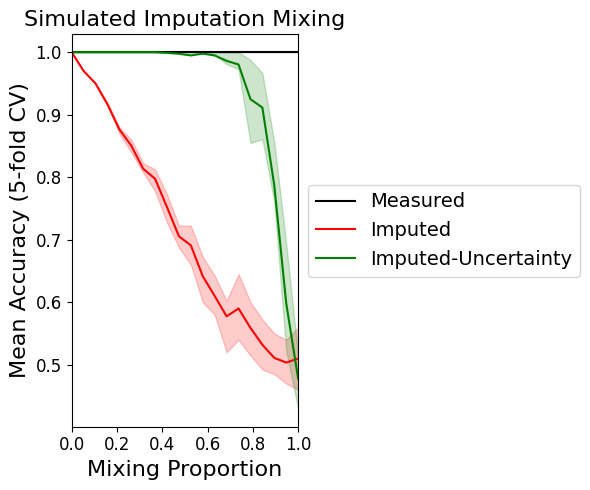

In [15]:
filename = "simulated_mix_0_1_20_default_params_20rep_FINAL_filterotsu"
mix_props = np.linspace(0,1,20)
start = 0

########################################
with open(f"results/prediction/{filename}.pkl", "rb") as f:
    mix_dict = pickle.load(f)

plt.figure(figsize=(6,5))

plt.plot(mix_props[start:], mix_dict["measured"]["mean_acc"][start:], label="Measured", color="k")
plt.plot(mix_props[start:], mix_dict["imputed"]["mean_acc"][start:], label="Imputed", color="r")
plt.plot(mix_props[start:], mix_dict["imputed_filtered"]["mean_acc"][start:], label="Imputed-Uncertainty", color="g")

plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["measured"]["range_acc"]][start:],
                 [x[1] for x in mix_dict["measured"]["range_acc"]][start:], color="k", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed"]["range_acc"]][start:],
                 [x[1] for x in mix_dict["imputed"]["range_acc"]][start:], color="r", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed_filtered"]["range_acc"]][start:],
                 [x[1] for x in mix_dict["imputed_filtered"]["range_acc"]][start:], color="g", alpha=0.2)

plt.title("Simulated Imputation Mixing", fontsize=16)
plt.xlabel(r"Mixing Proportion", fontsize=16)
plt.ylabel("Mean Accuracy (5-fold CV)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlim(np.min(mix_props[start:]),np.max(mix_props[start:]))
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/{filename}_ACC.pdf", bbox_inches="tight")
plt.show()

### Matching filter_proportion to mixing_proportion

In [ ]:
mix_props = np.linspace(0,0.9,20)


mix_dict = {}
for key in ["measured", "imputed", "imputed_filtered"]:
    mix_dict[key] = {}
    mix_dict[key]["mean_acc"] = []
    mix_dict[key]["range_acc"] = []


for mix in mix_props:
    
    measured_accs = []
    imputed_accs = []
    imputed_filtered_accs = []

    filter_proportion = mix
    
    for i in range(20):
    
        adata, calib_genes, labels = simulate_data(mu=10, p=1000, mixing=mix)
        true_clusters = labels

        # build spatial graph
        build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)
        calc_adjacency_weights(adata, method="cosine")

        # conformalize
        conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                         grouping_method="kmeans_gene_cell", k=2, k2=2, n_pc=15)

        # get PI's
        conformalize_prediction_interval(adata, "sim_predicted_expression", calib_genes, alpha_level=0.23)
        
        predicted = "sim_predicted_expression"

        # Imputed - Uncertainty
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.obsm[predicted].values
        splits = kf.split(X, labels)
        unc_acc = []
        for i, (train_index, test_index) in enumerate(splits):
            # get train tesst
            X_train = X[train_index,:].copy()
            X_train_pi_width = adata.obsm[f'{predicted}_hi'].values[train_index,:] - adata.obsm[f'{predicted}_lo'].values[train_index,:]
            y_train = labels[train_index]
            X_test = X[test_index,:].copy()
            X_test_pi_width = adata.obsm[f'{predicted}_hi'].values[test_index,:] - adata.obsm[f'{predicted}_lo'].values[test_index,:]
            y_test = labels[test_index]
            # filter both independently
            keep_idxs_train = detect_uncertain_cells (X_train_pi_width, proportion=filter_proportion, stratification=y_train)
            keep_idxs_test = detect_uncertain_cells (X_test_pi_width, proportion=filter_proportion, stratification=y_test)
            # fit model
            model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
            scaler = StandardScaler()
            X_train[keep_idxs_train,:] = scaler.fit_transform(X_train[keep_idxs_train,:])
            model.fit(X_train[keep_idxs_train,:], y_train[keep_idxs_train])
            # evaluate
            pred_y_test = model.predict(scaler.transform(X_test[keep_idxs_test,:]))
            unc_acc.append(accuracy_score(pred_y_test, y_test[keep_idxs_test]))
        unc_acc = np.mean(unc_acc)
        imputed_filtered_accs.append(unc_acc)

        # Imputed
        model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.obsm[predicted].values
        X = StandardScaler().fit_transform(X)
        imp_acc = cross_val_score(model, X, labels, cv=kf).mean()
        imputed_accs.append(imp_acc)

        # Measured
        model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
        X = adata.X
        X = StandardScaler().fit_transform(X)
        measured_acc = cross_val_score(model, X, labels, cv=kf).mean()
        measured_accs.append(measured_acc)
        
        
    # append results
    mix_dict["measured"]["mean_acc"].append(np.nanmean(measured_accs))
    mix_dict["imputed"]["mean_acc"].append(np.nanmean(imputed_accs))
    mix_dict["imputed_filtered"]["mean_acc"].append(np.nanmean(imputed_filtered_accs))
    
    mix_dict["measured"]["range_acc"].append((np.nanquantile(measured_accs,0.25),(np.nanquantile(measured_accs,0.75))))
    mix_dict["imputed"]["range_acc"].append((np.nanquantile(imputed_accs,0.25),(np.nanquantile(imputed_accs,0.75))))
    mix_dict["imputed_filtered"]["range_acc"].append((np.nanquantile(imputed_filtered_accs,0.25),(np.nanquantile(imputed_filtered_accs,0.75))))

In [24]:
# # pickle dict
# with open(f"results/prediction/simulated_mix_0_1_20_default_params_20rep_FINAL_filtermatched.pkl", "wb") as f:
#     pickle.dump(mix_dict, f)

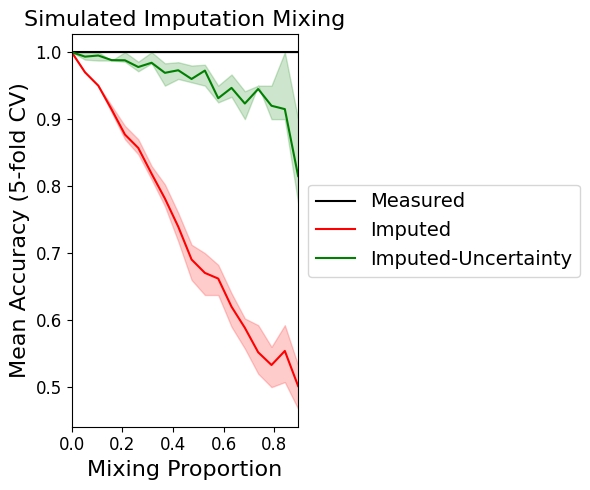

In [60]:
filename = "simulated_mix_0_1_20_default_params_20rep_FINAL_filtermatched"
mix_props = np.linspace(0,1,20)[:-2]
start = 0

########################################
with open(f"results/prediction/{filename}.pkl", "rb") as f:
    mix_dict = pickle.load(f)

plt.figure(figsize=(6,5))

plt.plot(mix_props[start:], mix_dict["measured"]["mean_acc"][start:], label="Measured", color="k")
plt.plot(mix_props[start:], mix_dict["imputed"]["mean_acc"][start:], label="Imputed", color="r")
plt.plot(mix_props[start:], mix_dict["imputed_filtered"]["mean_acc"][start:], label="Imputed-Uncertainty", color="g")

plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["measured"]["range_acc"]][start:],
                 [x[1] for x in mix_dict["measured"]["range_acc"]][start:], color="k", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed"]["range_acc"]][start:],
                 [x[1] for x in mix_dict["imputed"]["range_acc"]][start:], color="r", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed_filtered"]["range_acc"]][start:],
                 [x[1] for x in mix_dict["imputed_filtered"]["range_acc"]][start:], color="g", alpha=0.2)

plt.title("Simulated Imputation Mixing", fontsize=16)
plt.xlabel(r"Mixing Proportion", fontsize=16)
plt.ylabel("Mean Accuracy (5-fold CV)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlim(np.min(mix_props[start:]),np.max(mix_props[start:]))
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/{filename}_ACC.pdf", bbox_inches="tight")
plt.show()

## Cell filtering approach

In [27]:
dirnames = ["2023Feb20_k4k1_SDbasedCCplus1", "2023Mar4_k4k2_SDbasedCCplus1", "2023Mar4_k3k3_SDbasedCCplus1"]
dataset_names = ["Dataset13", "Dataset13", "Dataset14", "Dataset15", "Dataset15"]
metadata_labels = ["celltype", "celltype_lowres", "region", "Region", "ClusterName"]
methods = ['knn', 'spage', 'tangram']
n_classes = 3
filter_proportion = "otsu" # 0.2, "otsu"

######################################


df_dict = {}
df_dict["Dataset"] = []
df_dict["Directory"] = []
df_dict["Label"] = []
df_dict["Imputation Method"] = []
df_dict["Approach"] = []
df_dict["Accuracy"] = []
df_dict["F1"] = []
df_dict["ROC_AUC"] = []

for dirname in dirnames:
    for di, d in enumerate(dataset_names):
        
        label = metadata_labels[di]
        
        adata = sc.read_h5ad(f"scg_results/scpi/{dirname}/{d}_knn_spage_tangram_SCPI.h5ad")

        # subset into observations falling into most prevalent classes (if specified)
        uniq_labels, counts = np.unique(adata.obs[label], return_counts=True)
        if len(uniq_labels) > n_classes:
            sorted_uniq_labels = uniq_labels[np.argsort(counts)][::-1][:n_classes]
            adata = adata[adata.obs[label].isin(sorted_uniq_labels)]

        for m in methods:
            
            predicted = f'{m}_predicted_expression'
            
            # get prediction intervals
            adata.obsm[f'{predicted}_hi'] = adata.obsm[f'{predicted}_hi_67']
            adata.obsm[f'{predicted}_lo'] = adata.obsm[f'{predicted}_lo_67']
            
            # Imputed - Uncertainty
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            splits = kf.split(X, adata.obs[label])
            unc_acc = []
            unc_f1 = []
            unc_roc_auc = []
            for i, (train_index, test_index) in enumerate(splits):
                # get train tesst
                X_train = X[train_index,:].copy()
                X_train_pi_width = adata.obsm[f'{predicted}_hi'].values[train_index,:] - adata.obsm[f'{predicted}_lo'].values[train_index,:]
                y_train = adata.obs[label].values[train_index]
                X_test = X[test_index,:].copy()
                X_test_pi_width = adata.obsm[f'{predicted}_hi'].values[test_index,:] - adata.obsm[f'{predicted}_lo'].values[test_index,:]
                y_test = adata.obs[label].values[test_index]
                # filter both independently
                keep_idxs_train = detect_uncertain_cells (X_train_pi_width, proportion=filter_proportion, stratification=y_train)
                keep_idxs_test = detect_uncertain_cells (X_test_pi_width, proportion=filter_proportion, stratification=y_test)
                # fit model
                model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
                scaler = StandardScaler()
                X_train[keep_idxs_train,:] = scaler.fit_transform(X_train[keep_idxs_train,:])
                model.fit(X_train[keep_idxs_train,:], y_train[keep_idxs_train])
                # evaluate
                pred_y_test = model.predict(scaler.transform(X_test[keep_idxs_test,:]))
                pred_y_test_scores = model.predict_proba(scaler.transform(X_test[keep_idxs_test,:]))
                unc_acc.append(accuracy_score(y_test[keep_idxs_test], pred_y_test))
                unc_f1.append(f1_score(y_test[keep_idxs_test], pred_y_test, average='macro'))
                unc_roc_auc.append(roc_auc_score(y_test[keep_idxs_test], pred_y_test_scores, multi_class='ovr'))
#                 pred_y_test = model.predict(scaler.transform(X_test))
#                 pred_y_test_scores = model.predict_proba(scaler.transform(X_test))
#                 unc_acc.append(accuracy_score(y_test, pred_y_test))
#                 unc_f1.append(f1_score(y_test, pred_y_test, average='micro'))
#                 unc_roc_auc.append(roc_auc_score(y_test, pred_y_test_scores, multi_class='ovr'))
            unc_acc = np.mean(unc_acc)
            unc_f1 = np.mean(unc_f1)
            unc_roc_auc = np.mean(unc_roc_auc)

            # Imputed
            model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            X = StandardScaler().fit_transform(X)
            imp_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            imp_acc = imp_dict['test_accuracy'].mean()
            imp_f1 = imp_dict['test_f1_macro'].mean()
            imp_roc_auc = imp_dict['test_roc_auc_ovr'].mean()

            # Measured
            model = LogisticRegression(penalty='l1', solver='liblinear')#, tol=1e-3, max_iter=500)
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.X
            X = StandardScaler().fit_transform(X)
            measured_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            measured_acc = measured_dict['test_accuracy'].mean()
            measured_f1 = measured_dict['test_f1_macro'].mean()
            measured_roc_auc = measured_dict['test_roc_auc_ovr'].mean()
            
            
            # Append results to dictionary
            df_dict["Dataset"] += [d,d,d]
            df_dict["Label"] += [label, label, label]
            df_dict["Directory"] += [dirname, dirname, dirname]
            df_dict["Imputation Method"] += [m,m,m]
            df_dict["Approach"] += ["Imputed", "Imputed-Uncertainty", "Measured"]
            df_dict["Accuracy"] += [imp_acc, unc_acc, measured_acc]
            df_dict["F1"] += [imp_f1, unc_f1, measured_f1]
            df_dict["ROC_AUC"] += [imp_roc_auc, unc_roc_auc, measured_roc_auc]

In [28]:
# with open(f"results/prediction/{dirname}_CellsClassAccuracy_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "wb") as f:
#     pickle.dump(df_dict, f)

In [36]:
df = pd.DataFrame(df_dict)
df["Dataset"] = [x.split("Dataset")[1] for x in df["Dataset"].values]
df["Dataset_Label"] = df["Dataset"] + df["Label"]

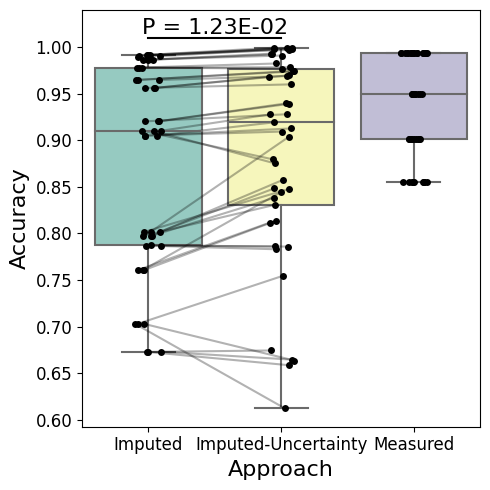

In [37]:
fig, ax = plt.subplots(figsize=(5,5))

sns.stripplot(data=df, x="Approach", y="Accuracy", c='k')
sns.boxplot(data=df, x="Approach", y="Accuracy", palette="Set3", showfliers=False)

# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [0.5]
y_coords = [1.01]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(df[df["Approach"]=="Imputed"]["Accuracy"], df[df["Approach"]=="Imputed-Uncertainty"]["Accuracy"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.03)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/predictionMetadata_LogReg_Cellapproach_67cutoff_ACC.pdf", bbox_inches="tight")
plt.show()

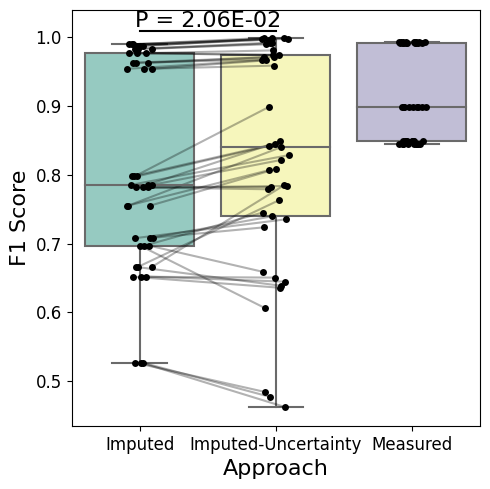

In [38]:
fig, ax = plt.subplots(figsize=(5,5))

sns.stripplot(data=df, x="Approach", y="F1", c='k')
sns.boxplot(data=df, x="Approach", y="F1", palette="Set3", showfliers=False)

# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [0.5]
y_coords = [1.01]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(df[df["Approach"]=="Imputed"]["F1"], df[df["Approach"]=="Imputed-Uncertainty"]["F1"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.03)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("F1 Score", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/predictionMetadata_LogReg_Cellapproach_67cutoff_F1.pdf", bbox_inches="tight")
plt.show()

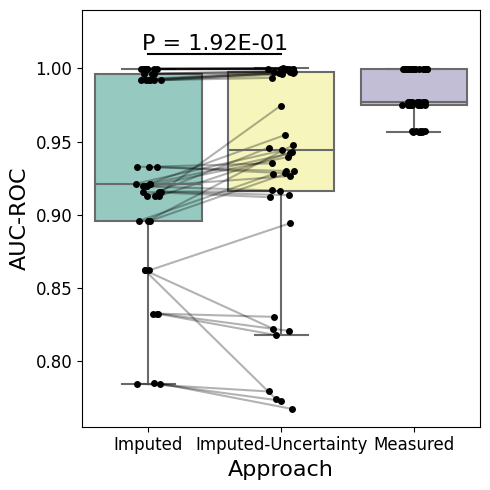

In [39]:
fig, ax = plt.subplots(figsize=(5,5))

sns.stripplot(data=df, x="Approach", y="ROC_AUC", c='k')
sns.boxplot(data=df, x="Approach", y="ROC_AUC", palette="Set3", showfliers=False)

# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [0.5]
y_coords = [1.01]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(df[df["Approach"]=="Imputed"]["ROC_AUC"], df[df["Approach"]=="Imputed-Uncertainty"]["ROC_AUC"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.03)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("AUC-ROC", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/predictionMetadata_LogReg_Cellapproach_67cutoff_AUCROC.pdf", bbox_inches="tight")
plt.show()

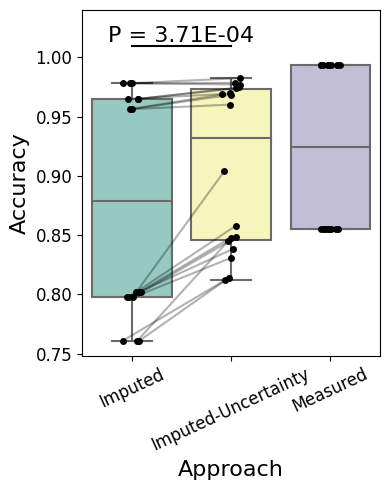

In [40]:
sub_df = df[df["Dataset"].isin(["15"])]

fig, ax = plt.subplots(figsize=(4,5))

sns.stripplot(data=sub_df, x="Approach", y="Accuracy", c='k')
sns.boxplot(data=sub_df, x="Approach", y="Accuracy", palette="Set3", showfliers=False)

# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [0.5]
y_coords = [1.01]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(sub_df[sub_df["Approach"]=="Imputed"]["Accuracy"], sub_df[sub_df["Approach"]=="Imputed-Uncertainty"]["Accuracy"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.03)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.xticks(fontsize=12, rotation=25)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/predictionMetadata_LogReg_Cellapproach_67cutoff_sub15_ACC.pdf", bbox_inches="tight")
plt.show()

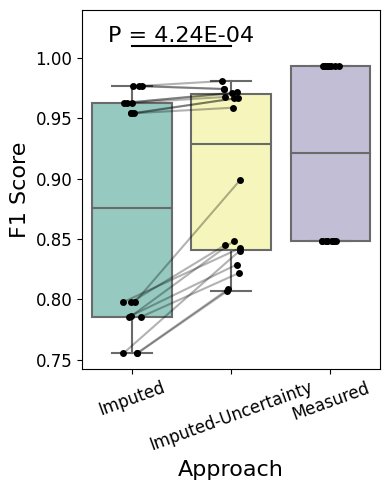

In [41]:
sub_df = df[df["Dataset"].isin(["15"])]

fig, ax = plt.subplots(figsize=(4,5))

sns.stripplot(data=sub_df, x="Approach", y="F1", c='k')
sns.boxplot(data=sub_df, x="Approach", y="F1", palette="Set3", showfliers=False)

# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [0.5]
y_coords = [1.01]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(sub_df[sub_df["Approach"]=="Imputed"]["F1"], sub_df[sub_df["Approach"]=="Imputed-Uncertainty"]["F1"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.03)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("F1 Score", fontsize=16)
plt.xticks(fontsize=12, rotation=20)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/predictionMetadata_LogReg_Cellapproach_67cutoff_sub15_F1.pdf", bbox_inches="tight")
plt.show()

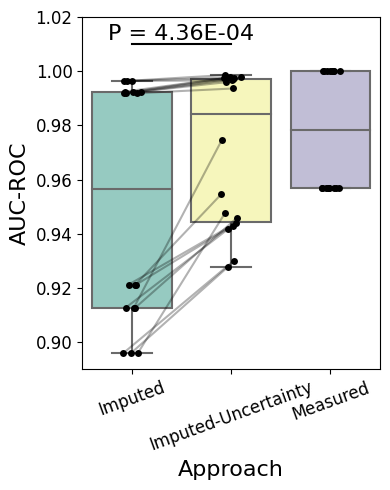

In [42]:
sub_df = df[df["Dataset"].isin(["15"])]

fig, ax = plt.subplots(figsize=(4,5))

sns.stripplot(data=sub_df, x="Approach", y="ROC_AUC", c='k')
sns.boxplot(data=sub_df, x="Approach", y="ROC_AUC", palette="Set3", showfliers=False)

# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [0.5]
y_coords = [1.01]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(sub_df[sub_df["Approach"]=="Imputed"]["ROC_AUC"], sub_df[sub_df["Approach"]=="Imputed-Uncertainty"]["ROC_AUC"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.01)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("AUC-ROC", fontsize=16)
plt.xticks(fontsize=12, rotation=20)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/scpi_prediction/predictionMetadata_LogReg_Cellapproach_67cutoff_sub15_AUCROC.pdf", bbox_inches="tight")
plt.show()